<a href="https://colab.research.google.com/github/cbeckler/final_project/blob/cb_etl/PM_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,026 kB]
Get:13 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main Sources [2,403 kB]
Get:14 

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2023-03-22 18:59:21--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  --.-KB/s    in 0.08s   

2023-03-22 18:59:21 (11.5 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
# start spark session that can connect to postgre
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("final-project").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd

cancer_path = "/content/drive/MyDrive/data/cancer_incidence.csv"

cancer_df = pd.read_csv(cancer_path, converters={' FIPS':'{:0>5}'.format})


cancer_df.head()

,index,County,FIPS,"Age-Adjusted Incidence Rate(Ê) - cases per 100,000",Lower 95% Confidence Interval,Upper 95% Confidence Interval,Average Annual Count,Recent Trend,Recent 5-Year Trend (ˆ) in Incidence Rates,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1
0,0,"US (SEER+NPCR)(1,10)",00000,62.4,62.3,62.6,214614,falling,-2.5,-3,-2
1,1,"Autauga County, Alabama(6,10)",01001,74.9,65.1,85.7,43,stable,0.5,-14.9,18.6
2,2,"Baldwin County, Alabama(6,10)",01003,66.9,62.4,71.7,170,stable,3,-10.2,18.3
3,3,"Barbour County, Alabama(6,10)",01005,74.6,61.8,89.4,25,stable,-6.4,-18.3,7.3
4,4,"Bibb County, Alabama(6,10)",01007,86.4,71,104.2,23,stable,-4.5,-31.4,32.9


In [13]:
# get rid of recent trend nulls (stored as *, _, __)

cancer_df = cancer_df.loc[(cancer_df['Recent Trend']=='rising')|(cancer_df['Recent Trend']=='falling')|(cancer_df['Recent Trend']=='stable')]

cancer_df['Recent Trend'].value_counts()

stable     2429
falling     200
rising       43
Name: Recent Trend, dtype: int64

In [14]:
cancer_df = cancer_df[[" FIPS", "Recent Trend"]]
cancer_df.rename(columns={' FIPS':'FIPS'}, inplace=True)

<ipython-input-14-58b290a8d909>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_df.rename(columns={' FIPS':'FIPS'}, inplace=True)


In [15]:
cancer_df.head()

,FIPS,Recent Trend
0,00000,falling
1,01001,stable
2,01003,stable
3,01005,stable
4,01007,stable


In [16]:
# get pm data

pm_path = "/content/drive/MyDrive/data/Daily_PM2.5_Concentrations_All_County__2001-2016.csv"

pm_df = pd.read_csv(pm_path, converters={'statefips': '{:0>2}'.format, 'countyfips': '{:0>3}'.format})

pm_df.head()

,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
0,2001,01JAN2001,01,001,10.664367,10.264546,10.137631,10.188703
1,2001,01JAN2001,01,003,9.803209,8.739505,8.743748,8.811486
2,2001,01JAN2001,01,005,12.087599,11.809159,11.812775,11.802062
3,2001,01JAN2001,01,007,8.579425,8.435394,8.458118,8.448871
4,2001,01JAN2001,01,009,14.399446,13.577741,13.300528,13.231461


In [17]:
# filter pollution data for years matching cancer data
pm_df = pm_df.loc[pm_df['year']<=2014]

In [9]:
# check years
pm_df.year.unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014])

In [18]:
# create state + county FIPS to match cancer data FIPS

pm_df['FIPS'] = pm_df['statefips'].astype(str) + pm_df['countyfips'].astype(str)

pm_df['FIPS'] = pm_df['FIPS'].astype(int)

pm_df.head()

,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,FIPS
0,2001,01JAN2001,01,001,10.664367,10.264546,10.137631,10.188703,1001
1,2001,01JAN2001,01,003,9.803209,8.739505,8.743748,8.811486,1003
2,2001,01JAN2001,01,005,12.087599,11.809159,11.812775,11.802062,1005
3,2001,01JAN2001,01,007,8.579425,8.435394,8.458118,8.448871,1007
4,2001,01JAN2001,01,009,14.399446,13.577741,13.300528,13.231461,1009


In [19]:
pm_df = pm_df[['year','date','PM25_max_pred','PM25_med_pred', 'PM25_mean_pred','PM25_pop_pred', 'FIPS']]

In [20]:
len(pm_df)

15896317

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='FIPS', ylabel='PM25_max_pred'>

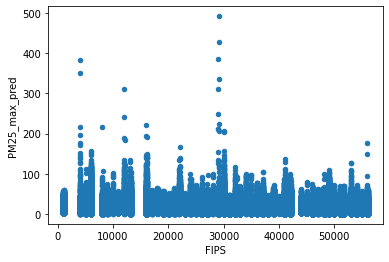

In [12]:
pm_df.plot(x='FIPS', y='PM25_max_pred', kind='scatter')

In [13]:
cancer_df.dtypes

index                                                  int64
County                                                object
 FIPS                                                 object
Age-Adjusted Incidence Rate(Ê) - cases per 100,000    object
Lower 95% Confidence Interval                         object
Upper 95% Confidence Interval                         object
Average Annual Count                                  object
Recent Trend                                          object
Recent 5-Year Trend (ˆ) in Incidence Rates            object
Lower 95% Confidence Interval.1                       object
Upper 95% Confidence Interval.1                       object
dtype: object

In [21]:
cancer_df["FIPS"] = pd.to_numeric(cancer_df["FIPS"])

In [13]:
cancer_df.dtypes

index                                                  int64
County                                                object
 FIPS                                                  int64
Age-Adjusted Incidence Rate(Ê) - cases per 100,000    object
Lower 95% Confidence Interval                         object
Upper 95% Confidence Interval                         object
Average Annual Count                                  object
Recent Trend                                          object
Recent 5-Year Trend (ˆ) in Incidence Rates            object
Lower 95% Confidence Interval.1                       object
Upper 95% Confidence Interval.1                       object
dtype: object

In [14]:
pm_df.dtypes

year                int64
date               object
statefips          object
countyfips         object
PM25_max_pred     float64
PM25_med_pred     float64
PM25_mean_pred    float64
PM25_pop_pred     float64
FIPS                int64
dtype: object

In [22]:
# merge cancer and pollution data to get only PM data that matches cancer dataset for EDA analysis

df = pd.merge(cancer_df, pm_df, how='inner', left_on='FIPS', right_on='FIPS')

df.head()

,FIPS,Recent Trend,year,date,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
0,1001,stable,2001,01JAN2001,10.664367,10.264546,10.137631,10.188703
1,1001,stable,2001,02JAN2001,16.231592,15.633819,15.660848,15.720587
2,1001,stable,2001,03JAN2001,13.596008,13.253824,13.247680,13.249806
3,1001,stable,2001,04JAN2001,14.943486,14.338261,14.287608,14.347044
4,1001,stable,2001,05JAN2001,14.890886,14.218863,14.236373,14.272212


In [24]:
# get row count
len(df)

13554563

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='FIPS', ylabel='PM25_max_pred'>

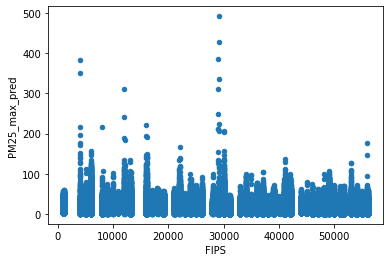

In [25]:
df.plot(x='FIPS', y='PM25_max_pred', kind='scatter')

In [26]:
# get count of unique FIPS
df.FIPS.nunique()

2651

In [27]:
# stats for max pred
pd.options.display.float_format = '{:20,.2f}'.format

df.PM25_max_pred.describe()

count          13,554,563.00
mean                   10.68
std                     5.68
min                     0.16
25%                     6.77
50%                     9.44
75%                    13.19
max                   491.53
Name: PM25_max_pred, dtype: float64

In [28]:
# stats for med pred
df.PM25_med_pred.describe()

count          13,554,563.00
mean                   10.21
std                     5.39
min                     0.09
25%                     6.47
50%                     9.05
75%                    12.64
max                   335.28
Name: PM25_med_pred, dtype: float64

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='FIPS', ylabel='PM25_med_pred'>

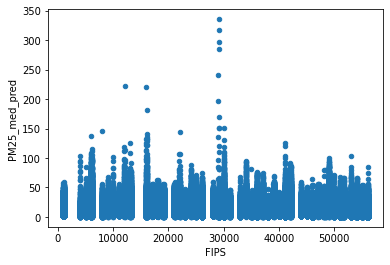

In [29]:
df.plot(x='FIPS', y='PM25_med_pred', kind='scatter')

In [30]:
# stats for mean pred
df.PM25_mean_pred.describe()

count          13,554,563.00
mean                   10.19
std                     5.37
min                     0.10
25%                     6.46
50%                     9.04
75%                    12.63
max                   385.23
Name: PM25_mean_pred, dtype: float64

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='FIPS', ylabel='PM25_mean_pred'>

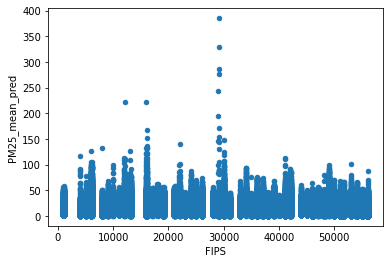

In [31]:
df.plot(x='FIPS', y='PM25_mean_pred', kind='scatter')

In [32]:
# stats for pop pred
df.PM25_pop_pred.describe()

count          13,554,563.00
mean                   10.20
std                     5.38
min                     0.10
25%                     6.46
50%                     9.04
75%                    12.63
max                   382.66
Name: PM25_pop_pred, dtype: float64

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='FIPS', ylabel='PM25_pop_pred'>

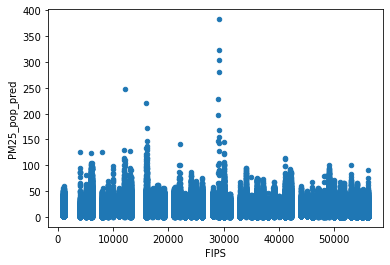

In [33]:
df.plot(x='FIPS', y='PM25_pop_pred', kind='scatter')

In [34]:
# investigate high PM FIPS

hi_df = df[(df['FIPS']>10000)&(df['FIPS']<31000)]

<Axes: xlabel='FIPS', ylabel='PM25_med_pred'>

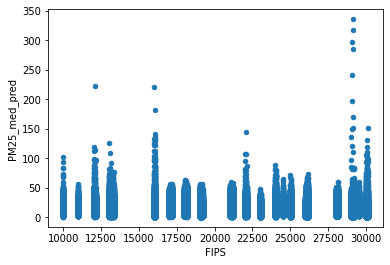

In [35]:
hi_df.plot(x='FIPS', y='PM25_med_pred', kind='scatter')

In [36]:
more_hi_df = hi_df[hi_df['FIPS']<29300]

<Axes: xlabel='FIPS', ylabel='PM25_med_pred'>

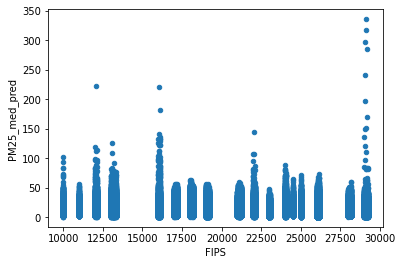

In [37]:
more_hi_df.plot(x='FIPS', y='PM25_med_pred', kind='scatter')

In [38]:
# identify top values

more_hi_df.sort_values('PM25_med_pred', ascending=False)

,FIPS,Recent Trend,year,date,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
6478426,29125,stable,2001,13SEP2001,491.53,335.28,385.23,382.66
6544895,29151,stable,2001,13SEP2001,428.69,316.72,329.52,323.51
6345488,29073,falling,2001,13SEP2001,385.53,296.40,286.04,304.04
6570460,29161,stable,2001,13SEP2001,334.58,284.35,276.45,280.36
6299471,29055,stable,2001,13SEP2001,309.95,240.18,242.96,229.26
...,...,...,...,...,...,...,...,...
2606608,16079,stable,2012,15MAR2012,0.34,0.31,0.31,0.31
5082111,23009,stable,2014,04JUN2014,0.55,0.29,0.31,0.30
5107676,23019,stable,2014,04JUN2014,1.27,0.29,0.37,0.34
5302111,25015,stable,2014,23OCT2014,0.38,0.29,0.29,0.29


In [39]:
# sort values of top FIP to see if there are multiple high values

df[df['FIPS']==29125].sort_values('PM25_med_pred', ascending=False)

# there are not--possibly outlier?

,FIPS,Recent Trend,year,date,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
6478426,29125,stable,2001,13SEP2001,491.53,335.28,385.23,382.66
6478384,29125,stable,2001,02AUG2001,67.85,56.12,59.32,59.05
6479885,29125,stable,2005,11SEP2005,41.98,41.20,41.11,41.10
6481523,29125,stable,2010,07MAR2010,39.62,39.18,39.11,39.14
6478390,29125,stable,2001,08AUG2001,40.38,38.28,38.49,38.39
...,...,...,...,...,...,...,...,...
6483037,29125,stable,2014,29APR2014,2.18,2.16,2.16,2.16
6478437,29125,stable,2001,24SEP2001,2.10,2.08,2.06,2.06
6482832,29125,stable,2013,06OCT2013,1.94,1.94,1.92,1.92
6483205,29125,stable,2014,14OCT2014,1.52,1.48,1.37,1.37


In [40]:
# sort the values of the high FIP by the month to see if the spike is sudden
df[(df['FIPS']==29125)&(df['date'].str.contains('SEP2001'))]
# it is--possibly an outlier??

,FIPS,Recent Trend,year,date,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
6478414,29125,stable,2001,01SEP2001,10.78,10.30,10.44,10.44
6478415,29125,stable,2001,02SEP2001,11.50,10.96,10.97,10.94
6478416,29125,stable,2001,03SEP2001,14.02,13.42,13.52,13.52
6478417,29125,stable,2001,04SEP2001,13.57,12.61,12.82,12.79
6478418,29125,stable,2001,05SEP2001,22.08,21.24,21.40,21.46
6478419,29125,stable,2001,06SEP2001,13.46,13.01,13.11,13.09
6478420,29125,stable,2001,07SEP2001,34.32,26.97,29.31,29.19
6478421,29125,stable,2001,08SEP2001,4.75,4.75,4.74,4.74
6478422,29125,stable,2001,09SEP2001,4.54,4.53,4.46,4.44
6478423,29125,stable,2001,10SEP2001,18.02,15.01,15.96,15.91


In [ ]:
https://aaqr.org/articles/aaqr-20-05-oa-0217

# the study linked above talks about variability in PM measurements
## based on both their findings and my exploratory analysis, it might be worthwhile to remove measurements >100 as outliers